# Consolidating historical urban population density data

In this module I work to use the popular Pandas data science library for Python to ingest, clean, and merge 90 years of decennial historical data. I use modern interpolation techniques to interfill missing data values between decennial counts, and validate with cross references to external databases.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Data Ingest

In [213]:
#initialize the pandas dataframe that will hold all historical data
df_columns = ['city', 'state', 'population', 'square_miles', 'population_density', 'year']
unclean_df = pd.DataFrame(columns = df_columns)
year = 1910  #the data doesn't hold the year inherently so I have to manually count and then interpolate it between decade counts
id = 1  #primary key

#below function iterates over all the files in the directory and appends them to the main pandas DataFrame
for filename in os.listdir('PopulationDensityData'):
    filename = 'PopulationDensityData/' + filename
    file = open(filename, 'r')  #opens the file to read
    
    for line in file:
        line = line.strip()
        row_dict = {}  #make a row dictionary to insert into a df for each line

        population = line[30:42].strip().replace(',','')
        sq_mi = line[41:49].strip().replace(',','')
        comma = line.index(',')
        city = line[4:comma].strip()
        state = line[comma+2:comma+4]
        pop_dens = line[line.rfind(' '):].strip().replace(',','')
        
        if id % 100 == 0:
            population = line[31:42].strip().replace(',','')
            sq_mi = line[42:50].strip().replace(',','')
        
        row_dict['city'] = [city]
        row_dict['year'] = [int(year)]
        row_dict['state'] = [state]
        row_dict['population'] = [float(population)]
        row_dict['square_miles'] = [float(sq_mi)]
        row_dict['population_density'] = [float(pop_dens)]
        id += 1
        
        row_df = pd.DataFrame(row_dict)
        unclean_df = unclean_df.append(row_df)
    year += 10  #next file is 10 years later

unclean_df

,city,state,population,square_miles,population_density,year
0,New York city,NY,4766883.0,286.8,16621.0,1910
0,Chicago city,IL,2185283.0,185.1,11806.0,1910
0,Philadelphia city,PA,1549008.0,130.2,11897.0,1910
0,St. Louis city,MO,687029.0,61.4,11189.0,1910
0,Boston city,MA,670585.0,41.1,16316.0,1910
...,...,...,...,...,...,...
0,Little Rock city,AR,175795.0,102.9,1708.0,1990
0,Bakersfield city,CA,174820.0,91.8,1904.0,1990
0,Fremont city,CA,173339.0,77.0,2251.0,1990
0,Fort Wayne city,IN,173072.0,62.7,2760.0,1990


## Data Cleaning - Processing the DataFrame to a usable state for data science

In [313]:
unclean_df = unclean_df.reset_index().drop(columns=['index'])
unclean_df = unclean_df[unclean_df['state'].str.isalpha()]
unclean_df['year'] = pd.to_datetime(unclean_df['year'], format='%Y')

#interpolation time :(
interpolated_df = pd.DataFrame()
def create_interpolated_df(city):
    non_interpolated_df = unclean_df.query(f"city == '{city}'")
    diff_years = non_interpolated_df['year'].max() - non_interpolated_df['year'].min()
    diff_years = int(diff_years.days / 365)
    for yr in range(diff_years):
        if yr % 10 != 0:  #don't want to write over rows that hold the data I need
            calc_year = pd.to_datetime(non_interpolated_df['year'].min().year + yr, format='%Y')
            row_dict = {'year':calc_year,'city':city, 'state':unclean_df[unclean_df['city'] == city]['state'].iloc[0]}
            no_data_years = pd.DataFrame(row_dict, index=[yr])
            non_interpolated_df = non_interpolated_df.append(no_data_years)
    final = non_interpolated_df.sort_values('year')
    final = final.interpolate(method='linear')
    final = final.reset_index().drop(columns=['index'])
    return final

df = pd.DataFrame()
for city in unclean_df['city'].unique():
    city_df = create_interpolated_df(city)
    df = df.append(city_df)

unclean_df.shape
df.shape

(7525, 6)

## Exploratory Data Analysis

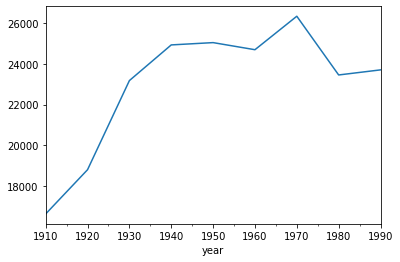

In [304]:
df.groupby('year')['population_density'].mean().plot(x='year', y='population_density')